**Assignment 03**

Reinforcement Learning

**Name**:Abhishek Patel

**Enrollment No**: 23565001

**Dept**: MFS-AI

**email**: abhishek_p@mfs.iitr.ac.in

#Question 01
**By using environment.ipynb file, generate the rewards for 10000 customers. Please use the seed as
 the sum of digits in your enrollment number. In this problem, we deploy Thompson Sampling based
 AI agent for maximizing the revenue and identifying the best marketing strategy.**

    (a) Plot the histogram for the number of times each marketing strategy was selected when you deploy
        Thompson Sampling based AI agent. (3 points)

    (b) Plot the histogram for the number of times each marketing strategy was selected when you deploy
      UCB and KL-UCB based AI agent. (3+3 points)

    (c) Plot the regret for Thompson sampling/UCB/KL-UCB based agent vs a random agent. Assume
      a random agent picks one of the nine marketing strategies uniformly at random. (1 points)

**Environment File**

In [ ]:
import numpy as np
#Enter the sum of digits in your enrollment number as seed

def environment(seed, customers):
  np.random.seed(seed)
  conversion_rates = np.random.uniform(0,0.2,9)
  Pmin=conversion_rates.min()
  Pmax=conversion_rates.max()
  Pavg=conversion_rates.mean()
  X = np.array(np.zeros([customers,9]))
  for i in range(customers):
    for j in range(9):
      if np.random.rand() <= conversion_rates[j]:
        X[i,j] = 1
  return X,conversion_rates.min(),conversion_rates.mean(),conversion_rates.max()



#--------------------------Manual Input-----------------------#
# Enrollment:23565001 (sum of digits=22)
seed = 22
customers = 10000
Reward_matrix,Pmin,Pavg,Pmax = environment(seed, customers)
print("Reward_matrix shape: ",Reward_matrix.shape)
print(f"Pmin: {round(Pmin,4)}, Pavg: {round(Pavg,4)}, Pmax: {round(Pmax,4)}")

Reward_matrix shape:  (10000, 9)
Pmin: 0.0342, Pavg: 0.0814, Pmax: 0.1718


**Function Decleration**

In [ ]:
#------------------------------Function Decleration---------------------#

# importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# creating class of multiarmed bandits

class MultiArmedBandit:
    def __init__(self, no_of_arms):
        self.arms = no_of_arms
        self.action_counts = np.zeros(no_of_arms)
        self.sum_rewards = np.zeros(no_of_arms)

    def pull_arm(self, arm,t):
        '''
        it will return reward and update action count corresponding to pulled arm.
        argument:
        1. arm=which arm you are pulling.
        2. t time step. (to pull reward from environment we need time)
        '''
        reward=Reward_matrix[t][arm] # pulling reward from environment cells.
        #reward=np.random.binomial(n=1,p=self.true_means[arm],size=1)
        self.action_counts[arm] += 1
        self.sum_rewards[arm] += reward
        return reward


    def draw_sample(self):
      '''
      this function will be used in thompson sampling only.
      it will used to draw sample.
      which distribution will generate larger value corresponding arm will be pulled.
      '''
      sample=np.zeros(self.arms)
      for arm in range(self.arms):
        success=self.sum_rewards[arm]
        failure=self.action_counts[arm]-success
        sample[arm]=np.random.beta(success+1,failure+1,size=1)
      return np.argmax(sample)

    def calculate_ucb_index(self,t):
      '''
      This function will be used in UCB sampling.
      argument: only t(time step) required.
      it will calculate ucb index corresponding to each arm and then arm corresponding to higher ucb index will get pulled.
      '''
      ucb=np.zeros(self.arms)
      emp_mean=self.sum_rewards/np.maximum(self.action_counts,1)
      for arm in range(self.arms):
        ucb[arm]=emp_mean[arm]+np.sqrt((2*np.log(t))/np.maximum(self.action_counts[arm],1))
      return np.argmax(ucb)

    def findKL(self,p,q):
      '''
      it will be used to calculate KL(p,q).
      '''
      return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

    def formula(self,p_hat,q,t,c,arm):
      '''
      this formula will be used in calculating optimum q value in UCB KL algorithm.
      '''
      return self.findKL(p_hat,q)-(np.log(t)+c*np.log(np.log(t)))/self.action_counts[arm]

    def binary_search(self,l,h,p_hat,t,c,arm):
      '''
      This function will be used to find root of equation using binary search method.
      this function will get used in KL UCB.
      '''
      if l>h:
        print("solution not found")
        return "Not found"
      q=(l+h)/2
      if np.isclose(q,1,atol=1e-3):
        return q
      if np.isclose(self.formula(p_hat,q,t,c,arm),0,atol=1e-6):
        return q
      elif self.formula(p_hat,q,t,c,arm)>0:
        return self.binary_search(l,q,p_hat,t,c,arm)
      else:
        return self.binary_search(q,h,p_hat,t,c,arm)


    def calculate_q_value(self,t,c):
      '''
      This function will calculate q value for KL ucb algorithm,
      '''
      emp_mean=self.sum_rewards/self.action_counts
      q_value=np.zeros(self.arms)
      for arm in range(self.arms):
        l=emp_mean[arm]
        h=1
        if l==1:
          q_value[arm]=1
        else:
          q_value[arm]=self.binary_search(l,h,l,t,c,arm)

      return np.argmax(q_value)

#-----------------------Thompson algorithm-------------------------#
def Thompson_execution_step(no_of_arms,epoch,T):
  full_action_count=np.zeros((epoch,no_of_arms))
  total_rewards=np.zeros((epoch,T))
  for i in (range(epoch)):
    bandit=MultiArmedBandit(no_of_arms)
    reward_per_epoch=np.zeros(T)
    for t in tqdm(range(T)):
      reward_per_epoch[t]=bandit.pull_arm(bandit.draw_sample(),t)
    full_action_count[i:]=bandit.action_counts
    total_rewards[i:]=reward_per_epoch

  return full_action_count.mean(axis=0),total_rewards.mean(axis=0)



#-----------------------UCB algorithm-------------------------#
def UCB_execution_step(no_of_arms,epoch,T):
  full_action_count=np.zeros((epoch,no_of_arms))
  total_rewards=np.zeros((epoch,T))
  for i in (range(epoch)):
    bandit=MultiArmedBandit(no_of_arms)
    reward_per_epoch=np.zeros(T)
    for t in range(no_of_arms):
      reward_per_epoch[t]=bandit.pull_arm(t,t)

    for t in tqdm(range(no_of_arms,T)):
      reward_per_epoch[t]=bandit.pull_arm(bandit.calculate_ucb_index(t+1),t)
    full_action_count[i:]=bandit.action_counts
    total_rewards[i:]=reward_per_epoch

  return full_action_count.mean(axis=0),total_rewards.mean(axis=0)


#-----------------------KL UCB algorithm-------------------------#
def KL_UCB(epoch,no_of_arms,T,c=3):
  '''
  It will take following input to calculate no of times each arm pulled and reward obtained.
  1. epoch: default =1
  2. no_of_arms
  3. T=sampling time period.
  4. c : constant c>=3
  '''
  full_action_count=np.zeros((epoch,no_of_arms))
  total_rewards=np.zeros((epoch,T))
  for i in (range(epoch)):
    bandit=MultiArmedBandit(no_of_arms)
    reward_per_epoch=np.zeros(T)
    for t in range(no_of_arms):
      reward_per_epoch[t]=bandit.pull_arm(t,t)

    for t in tqdm(range(no_of_arms,T)):
      reward_per_epoch[t]=bandit.pull_arm(bandit.calculate_q_value(t+1,c),t)
    full_action_count[i:]=bandit.action_counts
    total_rewards[i:]=reward_per_epoch

  return full_action_count.mean(axis=0),total_rewards.mean(axis=0)





##Question 01(a)
    Plot the histogram for the number of times each marketing strategy was selected when you deploy
    Thompson Sampling based AI agent. (3 points)

###(i) Thompson Sampling

  0%|          | 0/10000 [00:00<?, ?it/s]

No of selection corresponding to each marketing srategy:
1: 78.0, 2: 122.0, 3: 75.0, 4: 9239.0, 5: 51.0, 6: 106.0, 7: 79.0, 8: 201.0, 9: 49.0, 

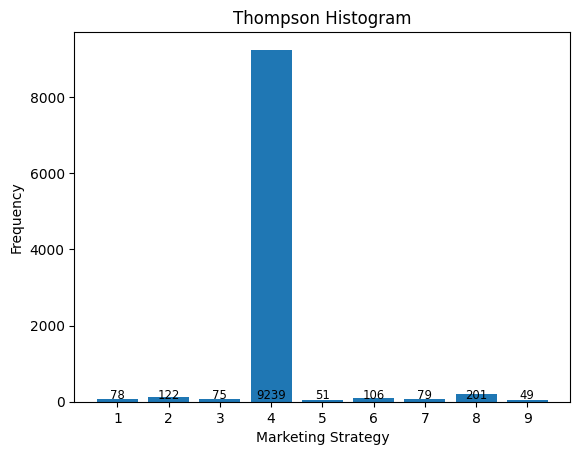

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

no_of_arms=9
T=customers # Number of customers.
epoch=1 # To Change epoch, first change the reward_matrix generated by environment.

# calling function
action_counts_thompson,reward_thompson=Thompson_execution_step(no_of_arms,epoch,T)



# printing no of times each marketing strategy is pulled.
print("No of selection corresponding to each marketing srategy:")
for i in range(len(action_counts_thompson)):
  print(f"{i+1}: {action_counts_thompson[i]}, ",end='')



#-------------Matplotlib plot----------------#
x=[x for x in range(1,10)]
plt.bar(x,action_counts_thompson)
for i in range(len(action_counts_thompson)):
    plt.text(x[i], x[i], str(round(action_counts_thompson[i])), ha='center',va='bottom',fontsize='small' )
plt.title('Thompson Histogram')
plt.xlabel('Marketing Strategy')
plt.ylabel('Frequency')
plt.xticks(list(range(1,10)))
plt.show()

##Question 01(b)
    Plot the histogram for the number of times each marketing strategy was selected when you deploy
    UCB and KL-UCB based AI agent.

###(i) UCB

  0%|          | 0/9991 [00:00<?, ?it/s]

No of selection corresponding to each marketing srategy:
1: 484.0, 2: 732.0, 3: 869.0, 4: 3428.0, 5: 447.0, 6: 635.0, 7: 655.0, 8: 2252.0, 9: 498.0, 

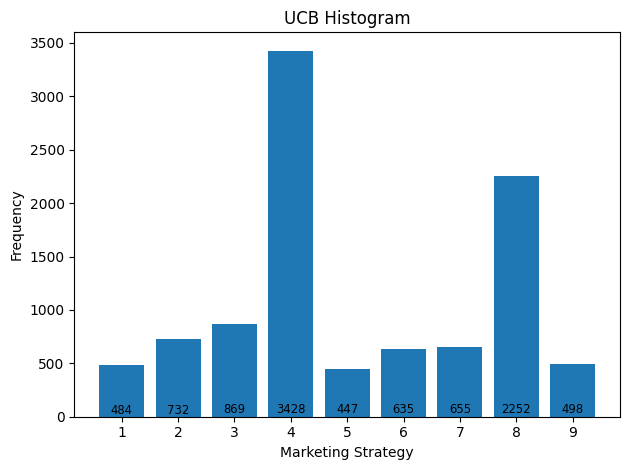

In [ ]:

no_of_arms=9
T=customers
epoch=1 # To Change epoch, first change the reward_matrix generated by environment.

# calling function
action_counts_ucb,reward_ucb=UCB_execution_step(no_of_arms,epoch,T)


# printing no of times each marketing strategy is pulled.
print("No of selection corresponding to each marketing srategy:")
for i in range(len(action_counts_ucb)):
  print(f"{i+1}: {action_counts_ucb[i]}, ",end='')

#-------------Matplotlib plot----------------#
x=[x for x in range(1,10)]
plt.bar(range(1,10),action_counts_ucb)
for i in range(len(action_counts_ucb)):
    plt.text(x[i], x[i], str(round(action_counts_ucb[i])), ha='center',va='bottom',fontsize='small' )
plt.title('UCB Histogram')
plt.xlabel('Marketing Strategy')
plt.ylabel('Frequency')
plt.xticks(list(range(1,10)))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

###(ii) KL-UCB

  0%|          | 0/9991 [00:00<?, ?it/s]

No of selection corresponding to each marketing srategy:
1: 210.0, 2: 349.0, 3: 434.0, 4: 6731.0, 5: 137.0, 6: 305.0, 7: 259.0, 8: 1399.0, 9: 176.0, 

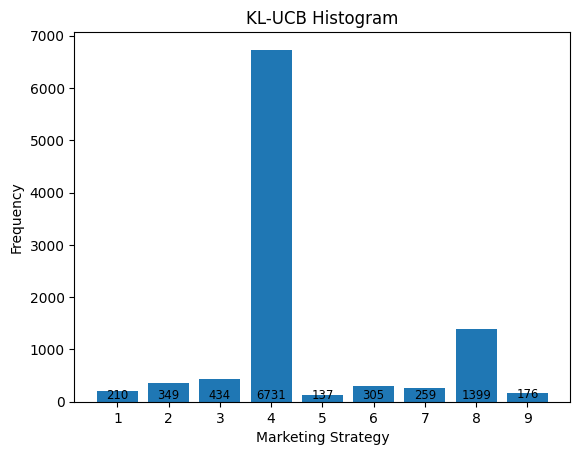

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

no_of_arms=9
T=customers
epoch=1 # To Change epoch, first change the reward_matrix generated by environment.
c=3 # constant used in KL UCB (c>=3)

# calling function
action_counts_KL_UCB,reward_KL_UCB=KL_UCB(epoch,no_of_arms,T,c)



# printing no of times each marketing strategy is pulled.
print("No of selection corresponding to each marketing srategy:")
for i in range(len(action_counts_KL_UCB)):
  print(f"{i+1}: {action_counts_KL_UCB[i]}, ",end='')



#-------------Matplotlib plot----------------#
x=[x for x in range(1,10)]
plt.bar(x,action_counts_KL_UCB)
for i in range(len(action_counts_KL_UCB)):
    plt.text(x[i], x[i], str(round(action_counts_KL_UCB[i])), ha='center',va='bottom',fontsize='small')
plt.title('KL-UCB Histogram')
plt.xlabel('Marketing Strategy')
plt.ylabel('Frequency')
plt.xticks(list(range(1,10)))
plt.show()

##Question 01(c)
    Plot the regret for Thompson sampling/UCB/KL-UCB based agent vs a random agent. Assume
    a random agent picks one of the nine marketing strategies uniformly at random. (1 points)

**Calculating Regret**

In [ ]:
# regret for thompson Sampling
import pandas as pd
Regret_thompson=Pmax*T-reward_thompson.sum()

# regret for UCB Sampling
Regret_ucb=Pmax*T-reward_ucb.sum()

# regret for KL_UCB Sampling
Regret_KL_UCB=Pmax*T-reward_KL_UCB.sum()

# regret for Random Sampling
Regret_random_agent=Pmax*T-Pavg*T

Algorithms=["Thompson","UCB","KL-UCB","Random Agent"]
Regret=[Regret_thompson,Regret_ucb,Regret_KL_UCB,Regret_random_agent]

regret_df=pd.DataFrame({"Algorithms":Algorithms,
                        "Regret":Regret
                        })
regret_df


,Algorithms,Regret
0,Thompson,56.363997
1,UCB,547.363997
2,KL-UCB,218.363997
3,Random Agent,904.616031


**Plotting Regret plot**

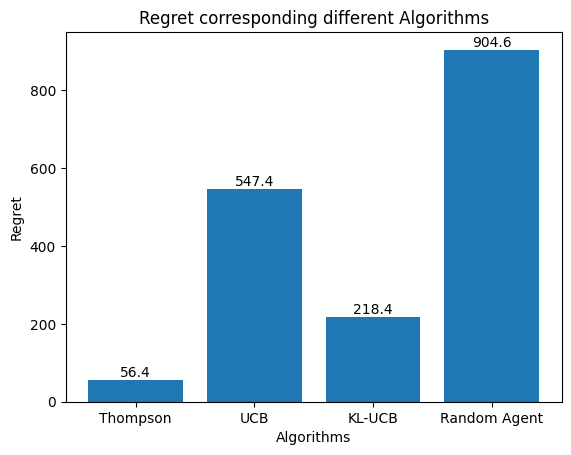

In [ ]:
#-------------Matplotlib plot----------------#
plt.bar(regret_df['Algorithms'],regret_df['Regret'])

for i in range(len(regret_df['Algorithms'])):
    plt.text(regret_df['Algorithms'][i], regret_df['Regret'][i], str(round(regret_df['Regret'][i],1)), ha='center',va='bottom' )

plt.ylabel("Regret")
plt.xlabel("Algorithms")
plt.title("Regret corresponding different Algorithms")
plt.show()